In [1]:
import pandas as pd 
import numpy as np 
import os 
import time
import logging 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from category_encoders import TargetEncoder

from tqdm.auto import tqdm
from itertools import combinations
import warnings
warnings.simplefilter('ignore')

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


In [5]:
train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


## EDA and Preprocessing

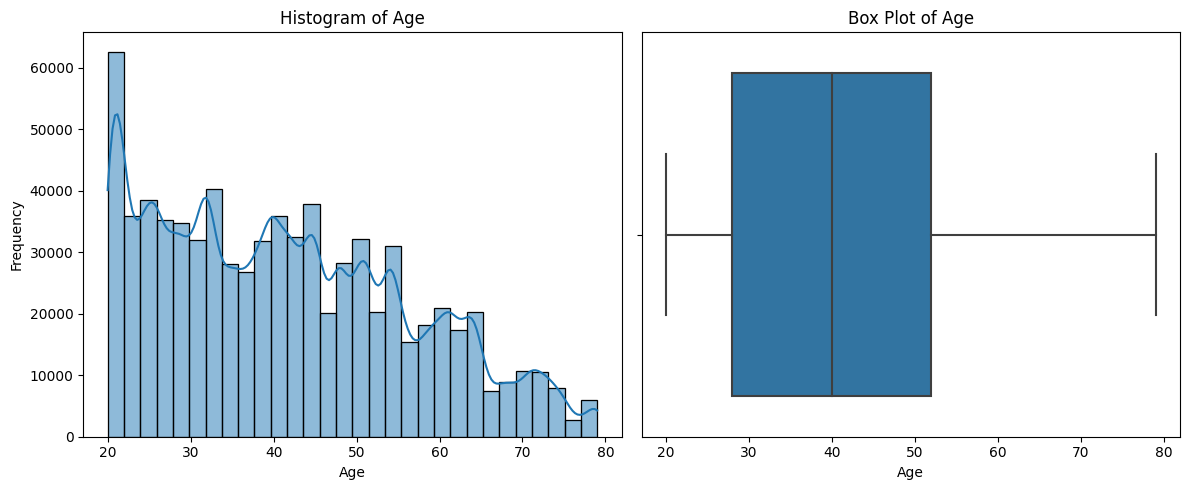


Statistics for Age:


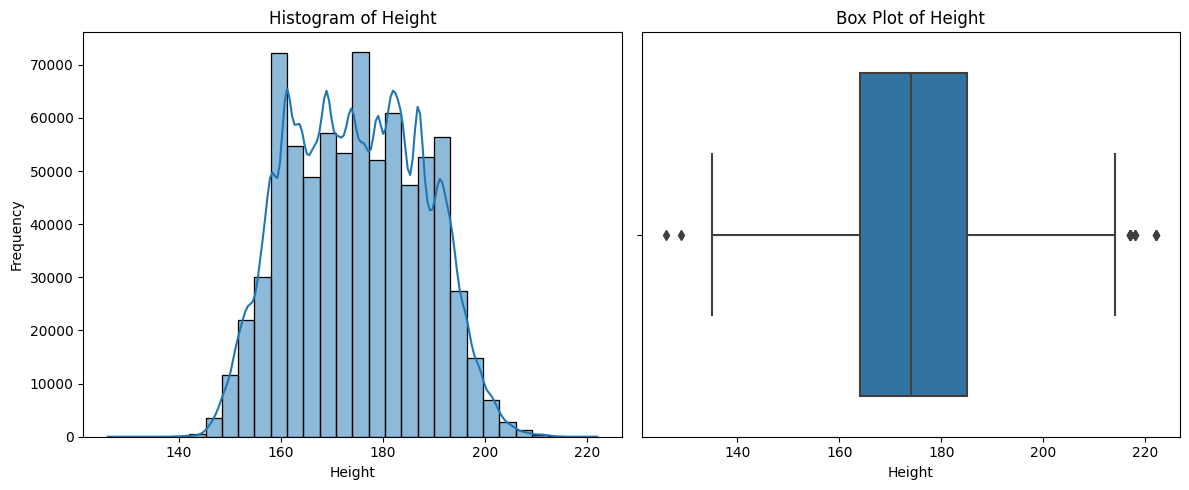


Statistics for Height:


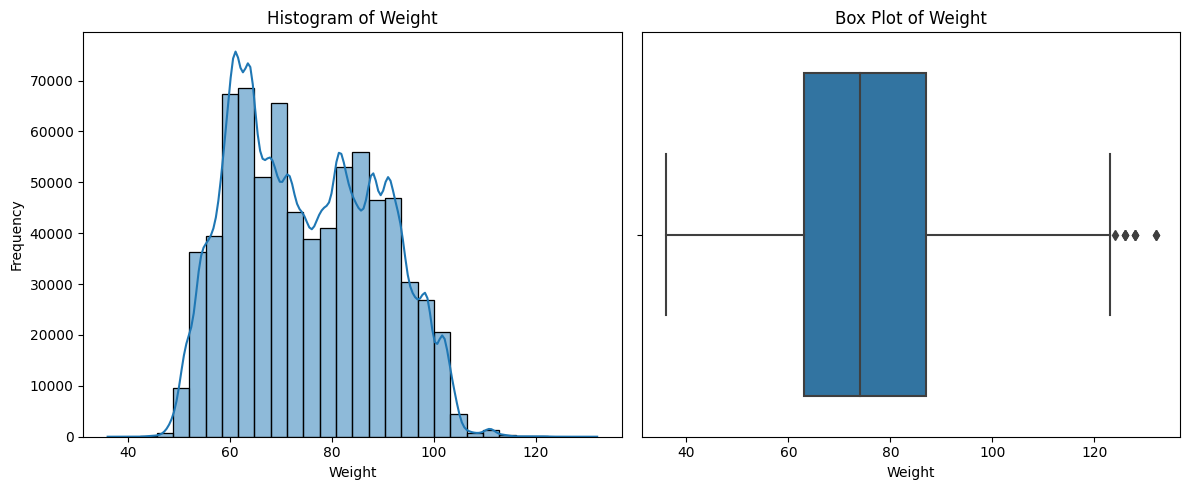


Statistics for Weight:


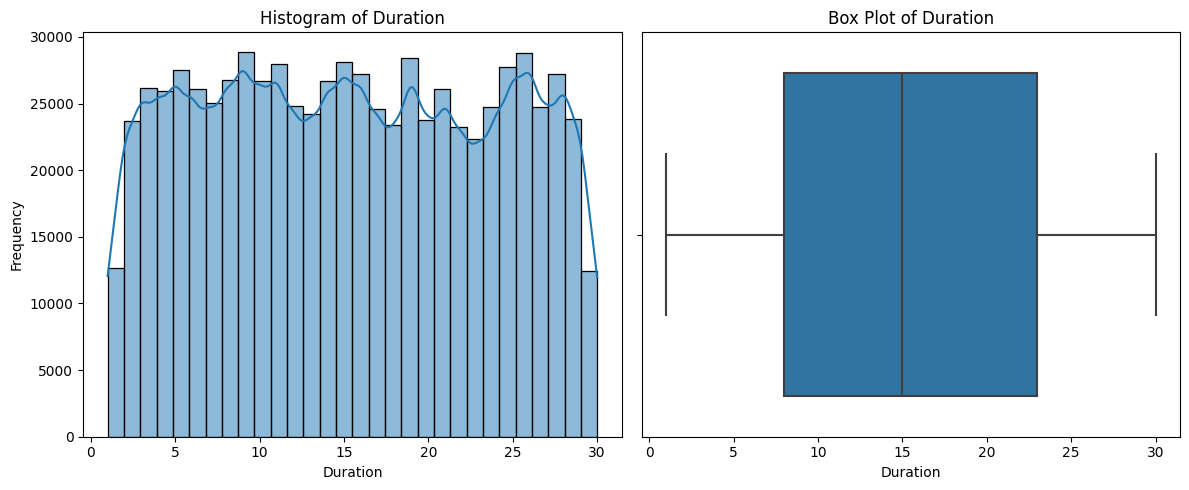


Statistics for Duration:


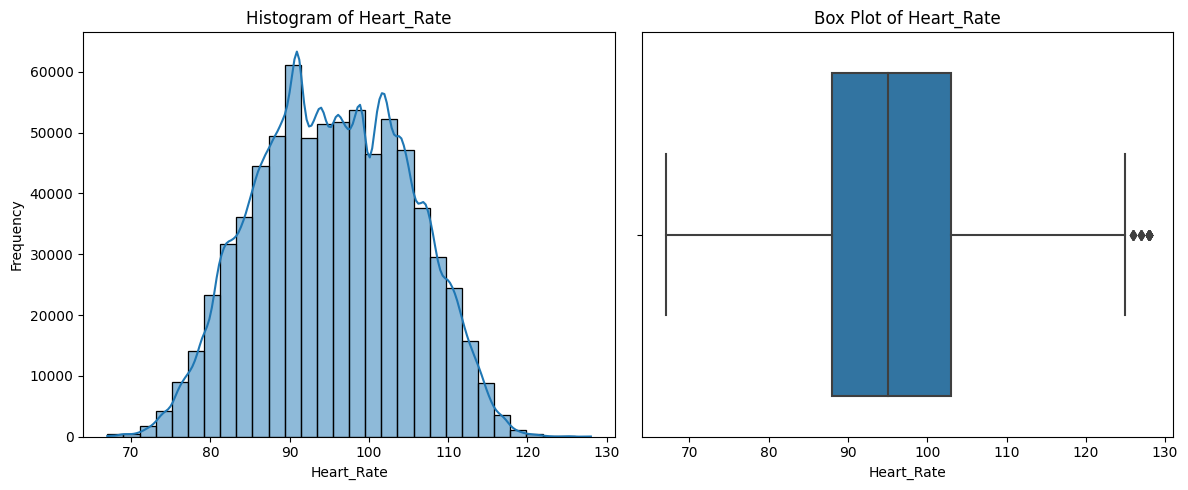


Statistics for Heart_Rate:


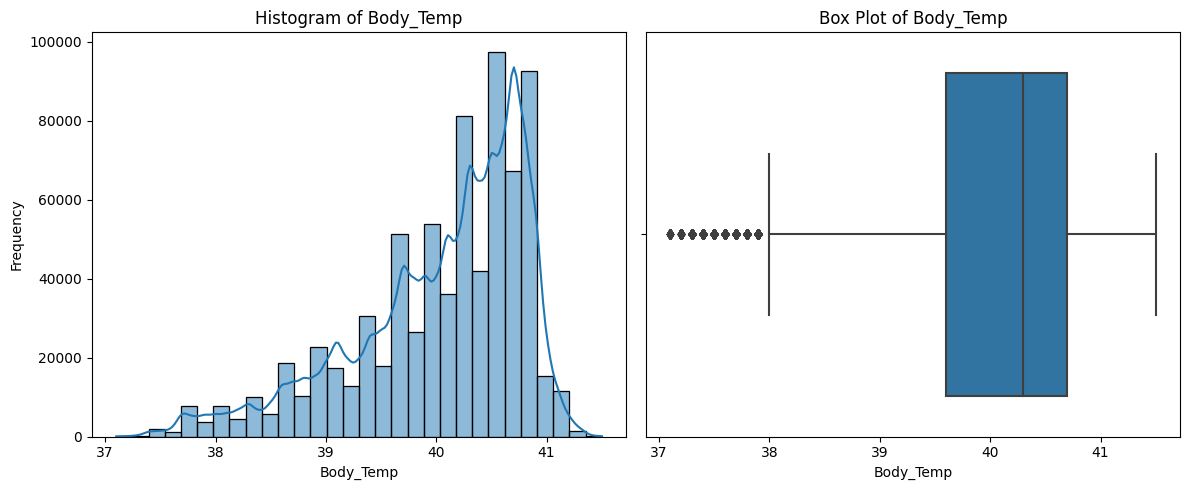


Statistics for Body_Temp:


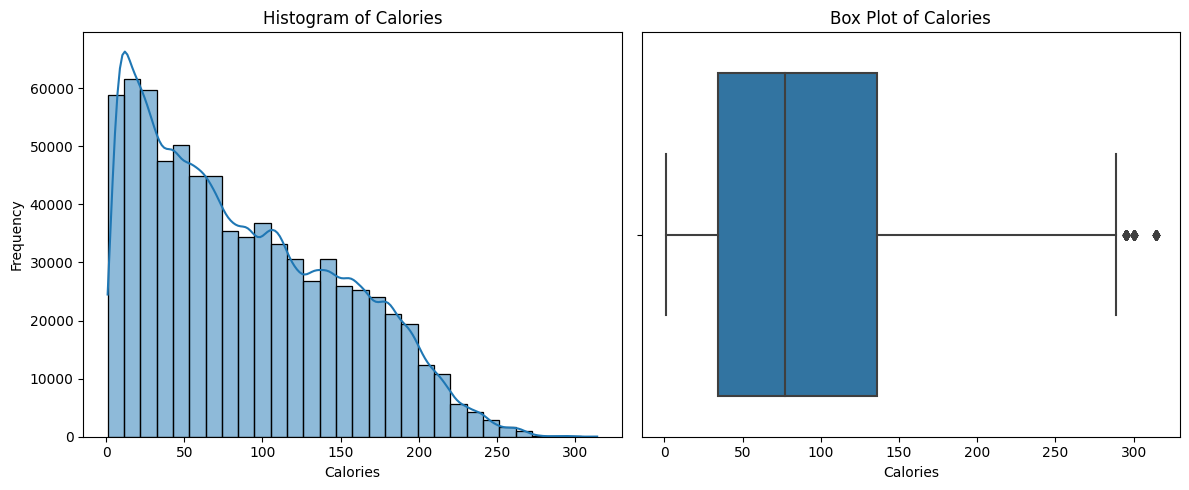


Statistics for Calories:


In [6]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp","Calories"]

for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(train[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()
    plt.show()

    print(f"\nStatistics for {feature}:")

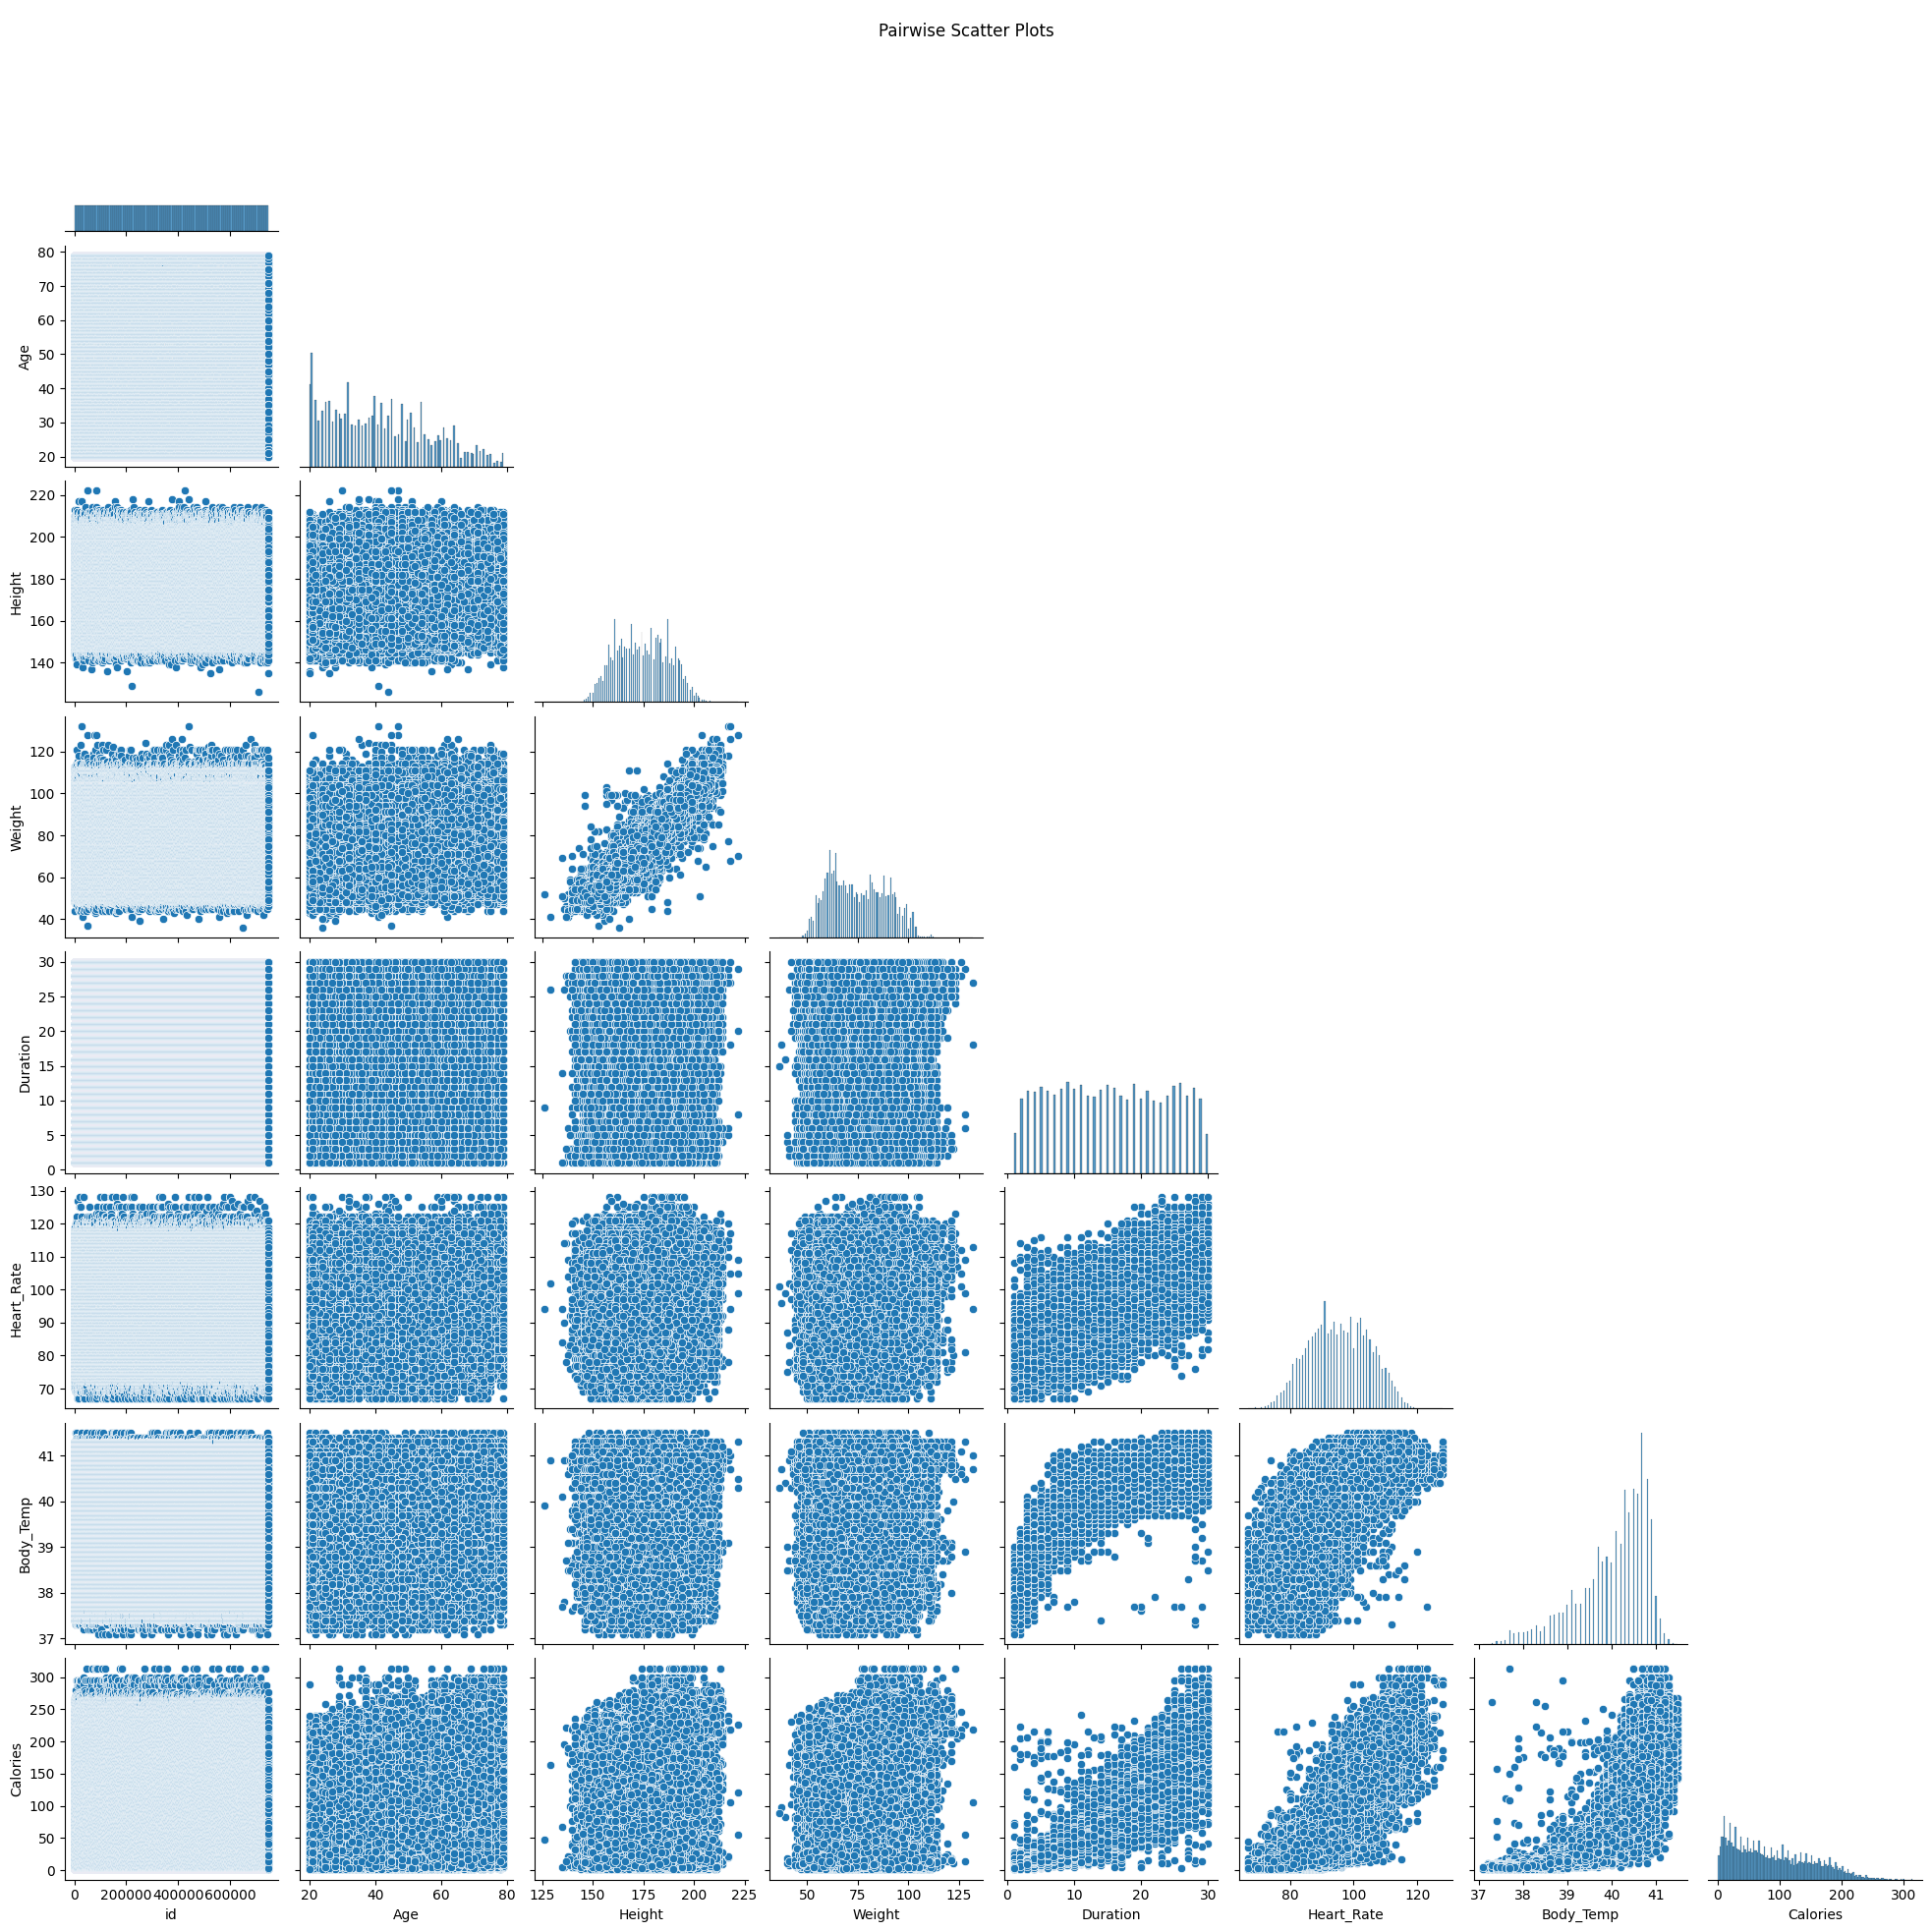

In [7]:
num_features = train.select_dtypes(include='number')

sns.pairplot(num_features, corner=True)
plt.suptitle('Pairwise Scatter Plots')
plt.show()

In [8]:
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])

X = train.drop(columns=["id", "Calories"])
y = np.log1p(train["Calories"])
X_test = test.drop(columns=["id"])

In [9]:
FOLDS = 3
FEATURES = X.columns.tolist()

# KFold setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Arrays to store predictions
oof = np.zeros(len(train))
pred = np.zeros(len(test))

# Start CV loop
for i, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n{'#'*10} Fold {i+1} {'#'*10}")
    
    x_train = X.iloc[train_idx].copy()
    y_train = y.iloc[train_idx]
    x_valid = X.iloc[valid_idx].copy()
    y_valid = y.iloc[valid_idx]
    x_test = X_test.copy()

    # No categorical target encoding in this dataset, but you can add if needed
    
    start = time.time()

    # Train model
    model = XGBRegressor(
        device="cuda" if XGBRegressor().get_params().get("device") == "cuda" else "cpu",
        max_depth=8,
        colsample_bytree=0.9,
        subsample=0.9,
        n_estimators=2000,
        learning_rate=0.01,
        early_stopping_rounds=25,
        eval_metric="rmse"
    )

    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=100
    )

    # Predict OOF and test
    oof[valid_idx] = model.predict(x_valid)
    pred += model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_idx]))
    print(f"Fold {i+1} RMSE: {rmse:.4f}")
    print(f"Feature engineering & training time: {time.time() - start:.1f} sec")

# Average test predictions
pred /= FOLDS

# Final RMSE
full_rmse = np.sqrt(mean_squared_error(y, oof))
print(f"\nFinal CV RMSE: {full_rmse:.4f}")


########## Fold 1 ##########
[0]	validation_0-rmse:0.95494
[100]	validation_0-rmse:0.36147
[200]	validation_0-rmse:0.14897
[300]	validation_0-rmse:0.08203
[400]	validation_0-rmse:0.06572
[500]	validation_0-rmse:0.06212
[600]	validation_0-rmse:0.06115
[700]	validation_0-rmse:0.06080
[800]	validation_0-rmse:0.06064
[900]	validation_0-rmse:0.06056
[1000]	validation_0-rmse:0.06050
[1100]	validation_0-rmse:0.06047
[1200]	validation_0-rmse:0.06045
[1204]	validation_0-rmse:0.06045
Fold 1 RMSE: 0.0605
Feature engineering & training time: 81.7 sec

########## Fold 2 ##########
[0]	validation_0-rmse:0.95278
[100]	validation_0-rmse:0.36036
[200]	validation_0-rmse:0.14801
[300]	validation_0-rmse:0.08092
[400]	validation_0-rmse:0.06454
[500]	validation_0-rmse:0.06091
[600]	validation_0-rmse:0.05993
[700]	validation_0-rmse:0.05956
[800]	validation_0-rmse:0.05939
[900]	validation_0-rmse:0.05931
[1000]	validation_0-rmse:0.05925
[1100]	validation_0-rmse:0.05922
[1200]	validation_0-rmse:0.05920
[1300]	

In [10]:
submission["Calories"] = np.expm1(pred)
submission.to_csv("submission.csv", index=False)
submission.head()

,id,Calories
0,750000,27.423471
1,750001,107.132869
2,750002,87.090536
3,750003,126.441693
4,750004,76.293043
